In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from utils.plotting import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find

from run_id import run_id
run_id = 385
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)

from shapely.geometry import Polygon

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import normalize

wos_all


In [2]:
from utils.text import *

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=1,
    max_features=10000000,
    ngram_range=(1,1),
    tokenizer=snowball_stemmer(),
    stop_words=stoplist
)

c_vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=1,
    max_features=10000000,
    ngram_range=(1,1),
    tokenizer=snowball_stemmer(),
    stop_words=stoplist
)

docs = Doc.objects.filter(query=q,content__iregex='\w')

In [3]:
old_vocab = []

X = []
X_count = []
n_words = []
for y in [1991,1996,2001,2006,2011,2016]:
#for y in [1991,1993]:
    docs = Doc.objects.filter(query=q,content__iregex='\w',PY=y)
    corpus, docsizes, ids = proc_docs(docs, stoplist)
    #X_y = tfidf_vectorizer.fit_transform(corpus)
    #X.append(X_y)
    print(y)
    X_y = c_vectorizer.fit_transform(corpus)
    X_count.append(X_y)
    
    vocab = c_vectorizer.get_feature_names()
    
    new_vocab = [i for i,x in enumerate(vocab) if x not in old_vocab]
    nv = [x for i,x in enumerate(vocab) if x not in old_vocab]
    
    sm = X_y[:,new_vocab]

    cts = np.asarray(sm.sum(0))[0]

    tts = cts.argsort()[-10:][::-1]

    nw_y = [nv[i] for i in tts]
    
    n_words.append(nw_y)
    
    print(nw_y)
    
    old_vocab = vocab

1991
['climat', 'chang', 'increas', 'use', 'model', 'atmospher', 'temperatur', 'carbon', 'effect', 'global']
1996
['norway', 'downscal', 'otc', 'litholog', 'infect', 'fog', 'sward', 'heinrich', 'timber', 'scot']
2001
['kyoto', 'degreesn', 'mum', 'degreess', 'mul', 'mug', 'mis', 'cdm', 'etch', 'amphibian']
2006
['seep', 'ecotyp', 'amo', 'eto', 'multiga', 'sciamachi', 'stover', 'symbiodinium', 'inuit', 'swe']
2011
['biochar', 'redd', 'doigl', 'aeuro', 'robinson', 'mcallist', 'mcginn', 'beauchemin', 'hao', 'jatropha']
2016
['cci', 'mmms', 'sif', 'awd', 'una', 'indc', 'nop', 'electrocatalyst', 'oli', 'emf']


In [4]:
import codecs
import re
bible = []
i=0
clines=""
corpus = []
lchapter="none"
with codecs.open('/home/galm/projects/big_literature/py/Martin_Luther_Uebersetzung_1912.txt',encoding = "ISO-8859-1") as ml:
    for line in ml:
        chapter = line.split(':')[0]
        try:
            verse = re.search(".*([0-9]+\:[0-9]*)(.*)",line).group(2).strip()
        except:
            corpus.append(str(clines))
            break
        if lchapter!=chapter and i > 0:
            corpus.append(str(clines))
            clines=verse            
        else:
            clines+=" "+verse
            #print('\n')
        lchapter = chapter
        i+=1
        
X_y = c_vectorizer.fit_transform(corpus)
X_count.append(X_y)

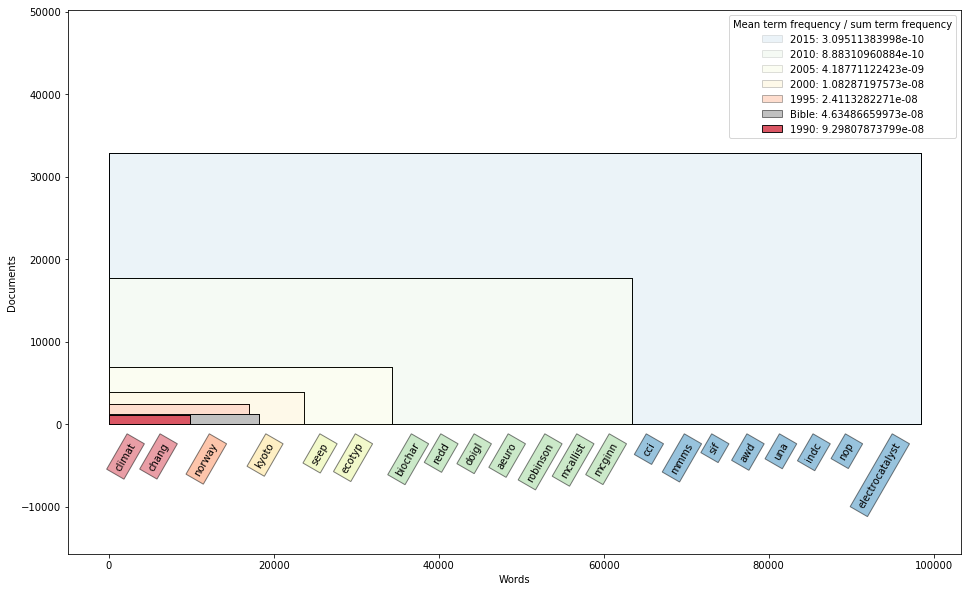

In [35]:
ind = np.arange(1)

plt.rcParams["figure.figsize"] = [16,10]


def vvrect(X,col_x,m):
    return plt.bar(ind+X.shape[1]/2,X.shape[0],width=X.shape[1],facecolor=col_x,edgecolor='black',alpha=m)

#X_count.append(X_y)

nmeans = normalize([[x.mean()/x.sum() for x in X_count]])[0]

crange = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc']

crange = ["#D53E4F", "#FC8D59", "#FEE08B", "#E6F598", "#99D594", "#3288BD","grey"]
#crange = ["grey", "grey", "grey", "grey", "grey", "grey","grey"]
years = [1990,1995,2000,2005,2010,2015,'Bible']



plots = []
lvalues = []

left = 0

for x in [5,4,3,2,1,6,0]:
    a = (nmeans[x]+0.1)/1.1
    #a = nmeans[x]
    vvrect(X_count[x], "None",1)
    vvrect(X_count[x], "white",1)
    p = vvrect(X_count[x], crange[x] ,a)
    plots.append(p[0])
    lvalues.append(str(years[x]) + ": " + str(X_count[x].mean()/X_count[x].sum()))

    if x < 6:
        ix = abs(5-x)
        right = X_count[ix].shape[1]
        gap = right - left
        l = left
        space = 4000
        for i in range(gap // space):
            if i < 10:
                plt.text(
                    l+space/2,-2000,n_words[abs(5-x)][i],
                    rotation=60,va="top",ha="center",
                    bbox={'facecolor': crange[ix], 'alpha':0.5, 'pad':5}
                )
                l+=space
        
    
    left = right
    
plt.legend(plots,lvalues,title='Mean term frequency / sum term frequency')
    
plt.axis('equal')
plt.ylabel('Documents')
plt.xlabel('Words')
plt.savefig('../plots/volume_variety_bible.png',bbox_inches='tight')

plt.show()

In [11]:
ind

array([0])